In [1]:
import numpy as np
import csv
from pydub import AudioSegment 
import matplotlib.pyplot as plt # naming convention for matplotlib
import waveform_analysis as wan #import A-weighting from https://github.com/endolith/waveform_analysis
from scipy.io import wavfile as wav
from scipy.fftpack import fft # import discrete fourier transform and its inverse
from scipy import signal
from scipy.io.wavfile import write
import json

## Convert file from log.bin to log.csv
# DO NOT RUN THIS IT'S JUST FOR REFERENCE
# RUN FROM SUBLIME

In [ ]:
csv = open('log.csv', 'w')
csv.write('counter, offset, time, sample\n')

# CONVERT SD CARD DATA TO CSV
# COUNTER, OFFSET, TIME, SAMPLE

with open("log.bin", "rb") as f:
    byte = f.read(4)
    count = 1
    separator = ', '
    while byte:
        unpacked = struct.unpack('i', byte)
        csv.write(str(unpacked[0]) + separator)
        byte = f.read(4)
        count += 1;
        separator = '\n' if (count % 4 == 0) else ', '

csv.close()
f.close()

## Clean up CSV file
##### you can run this here

In [ ]:
with open("log.csv",'r') as f:
    with open("log_edited.csv",'w') as f1:
        f.readline() # skip header line
        for line in f:
            f1.write(line)


# CONVERT CSV TO ARRAY

get_timer_reference = 0;

   #GETS ZERO-TH TIME
with open("log_edited.csv") as z:
    mycsv = csv.reader(z, quoting=csv.QUOTE_NONNUMERIC)
    mycsv = list(mycsv)
    get_timer_reference = int(mycsv[0][2])

    #CONVERTS TO INT ARRAY
with open("log_edited.csv") as csvfile:
    data = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    time, sample = [], []
    for row in data:
        time.append(int(row[2]) - get_timer_reference)
        sample.append(int(row[3]))
print("Success")

In [ ]:
plt.plot(time, sample) # change the indices to zoom in/out in time
plt.title('Waveform')
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.show()

## WAV Conversion

In [ ]:
scaled = np.int16(sample/np.max(np.abs(sample)) * 32767)
write('3lp_f_var.wav', 100000, scaled)

### M4A to WAV conversion

In [23]:
#Conversion from .m4a to .wav
#TO DO: Read file extension to decide if conversion necessary, catch errors if wrong file ext
fileName = "cf"
path = "piezo/" + fileName

sound = AudioSegment.from_file(path + ".m4a", format="m4a")
file_handle = sound.export(path + ".wav", format="wav")

wav_sound = AudioSegment.from_wav(path + ".wav")
wav_sound = wav_sound.set_channels(1)
wav_sound.export(path + ".wav", format="wav")

<_io.BufferedRandom name='piezo/cf.wav'>

##  Signal Processing 

##### for all your processing needs after WAV conversion

Currently displays waveform, FFT, spectrogram, and PSD.

NOTE: emily come edit this and normalize the y valus

In [20]:
#FOR EXAMPLE: Folder: Bone Transducer, fileName = BoneTransducer_T02_2
#don't include .wav for obvious reasons
folder = 'piezo'
fileName = 'piezo_chirp_healthy_1'
sampFreq, snd = wav.read(folder + "/" + fileName + '.wav')

fileName2 = 'piezo_chirp_cf_1'
sampFreq2, snd2 = wav.read(folder + "/" + fileName2 + '.wav')

fileName3 = 'cf'
sampFreq3, snd3 = wav.read(folder + "/" + fileName3 + '.wav')

print(snd)

[  0   0  -1 ... -64 -69 -36]


In [59]:
# PREPROCESSING DATA

# ZERO-MEAN 
snd = (snd - snd.mean()) / snd.std()
#snd = snd[50000:1450000] #used for dropouts






snd2 = (snd2 - snd2.mean()) / snd2.std()



snd3 = (snd3 - snd3.mean()) / snd3.std()



In [60]:
# 60 HZ INTERFERENCE NOTCH FILTER
f0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 40.0  # Quality factor
w0 = f0/(sampFreq/2)  # Normalized Frequency
# Design notch filter
b, a = signal.iirnotch(w0, Q)
snd = signal.filtfilt(b, a, snd)

# 60 HZ INTERFERENCE NOTCH FILTER
f0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 40.0  # Quality factor
w0 = f0/(sampFreq/2)  # Normalized Frequency
# Design notch filter
b, a = signal.iirnotch(w0, Q)
snd2 = signal.filtfilt(b, a, snd2)

# 60 HZ INTERFERENCE NOTCH FILTER
f0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 40.0  # Quality factor
w0 = f0/(sampFreq/2)  # Normalized Frequency
# Design notch filter
b, a = signal.iirnotch(w0, Q)
snd3 = signal.filtfilt(b, a, snd3)

##### Optional:  Rewrite wav file without 60 Hz noise

In [ ]:
scaled = np.int16(snd3/np.max(np.abs(snd)) * 32767)
write(folder + fileName3 + '_zeromean' + '.wav', 100000, scaled)

##### Actual Analysis

In [ ]:
#TO DO: Adjust indexing for FFT, catch errors that result (or just actually make a good FFT...)

# INITIALIZE
fig = plt.figure()

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(15,10))

file_len = len(snd)

# PLOT AUDIO WAVEFORM
timeArray = np.arange(0, len(snd), 1)
timeArray = timeArray / sampFreq
print("Length of file: " + str(len(snd)/sampFreq) + "s")
ax1.plot(timeArray, snd, color='k')
ax1.set_title('Audio Waveform')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
 
# CALCULATE FFT

dft = fft(snd[:600000]) # calculate fourier transform #if you want a 
N = len(dft) # length of discrete fourier transform
freqs = [i*sampFreq/N for i in range(N)] # convert from dft frequencies to Hz
#dft_norm = np.amax(np.abs(dft))
#ax2.plot(freqs, np.abs(dft)/dft_norm, color='k') # change the indices to zoom in/out in frequency
ax2.plot(freqs, np.abs(dft), color='k') # change the indices to zoom in/out in frequency
ax2.set_title('Freq Analysis')
ax2.set_xlabel('Frequencies (Hz)')
ax2.set_ylabel('DFT Coefficients')
ax2.set_xlim([0,1000])

# CALCULATE SPECTROGRAM

Pxx, freqs, bins, im = ax3.specgram(snd, NFFT=4096, Fs=sampFreq)
ax3.set_title('Spectrogram')
ax3.set_xlabel('Frequency')
ax3.set_ylabel('Magnitude')
ax3.set_ylim([0,1000])

# CALCULATE PSD (based on Welch)
f, Pxx_den = signal.welch(snd[:file_len], sampFreq, nperseg=2048, return_onesided=True, scaling='spectrum') #PLACE INDEX HERE
#Pxx_den_norm = np.amax(Pxx_den)
#ax4.plot(f, Pxx_den/Pxx_den_norm, color='k')
ax4.plot(f, Pxx_den, color='k')
ax4.set_title('PSD (Welch)')
ax4.set_xlabel('Frequency [Hz]')
ax4.set_ylabel('PSD [V^2/Hz]')
ax4.set_xlim([0,1000])

# POST-CALCULATION AESTHETIC

plt.suptitle('Results for ' + fileName, fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

In [ ]:
# this is a test box to try different plots without running the entire thing


In [ ]:
fig.savefig(folder + '/' + fileName +'.png', bbox_inches='tight')
print("Saved!")

In [ ]:
plt.close()

## EXPERIMENTAL

In [45]:
def rms_flat(a):
    a = np.sqrt(np.mean(np.abs(a)**2))
    return a

Aweighted1 = wan.A_weight(snd, sampFreq)
Aweighted_level1 = rms_flat(Aweighted1)

Aweighted2 = wan.A_weight(snd2, sampFreq)
Aweighted_level2 = rms_flat(Aweighted2)

Aweighted3 = wan.A_weight(snd3, sampFreq)
Aweighted_level3 = rms_flat(Aweighted3)

In [46]:
print(Aweighted_level1)
print(Aweighted_level2)
print(Aweighted_level3)

225.4613348345159
151.62348917949112
522.263640683791


In [ ]:
with open("spectrums/brp_cf_t06.csv") as csvfile:
    
    data = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    
    frequency, dB = [], []
    for row in data:
        frequency.append(int(row[0]))
        dB.append(int(row[1]))
        
with open("spectrums/brp_f_t06.csv") as csvfile:
    
    data = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    
    frequency2, dB2 = [], []
    for row in data:
        frequency2.append(int(row[0]))
        dB2.append(int(row[1]))
        
with open("spectrums/brp_h_t06.csv") as csvfile:
    
    data = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC)
    
    frequency3, dB3 = [], []
    for row in data:
        frequency3.append(int(row[0]))
        dB3.append(int(row[1]))
print("Success")


In [ ]:
fig = plt.figure()

plt.plot(frequency3, dB3, label="h", color='g')
plt.plot(frequency2, dB2, label="f", color='b')
plt.plot(frequency, dB, label="cf", color='r')
plt.title('dB vs Hz for 400Hz')
plt.xlabel('frequency [Hz]')
plt.ylabel('dB')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,1100)
plt.ylim([-100,0])
plt.show()

In [ ]:
fig.savefig('spectrums/brp_T04_nozeromean.png', bbox_inches='tight') #CHANGE HERE
print("Saved!")

In [18]:
s = 2048

pxx, freqs, bins, _ = plt.specgram(snd, NFFT=s, Fs=sampFreq, noverlap=s/2,
                                 sides='onesided',
                                   window=signal.hann(s),
                                   scale_by_freq=True,
                                   mode='magnitude')

pxx2, freqs2, bins2, _ = plt.specgram(snd2, NFFT=s, Fs=sampFreq, noverlap=s/2,
                                 sides='onesided',
                                   window=signal.hann(s),
                                   scale_by_freq=True,
                                   mode='magnitude')

#pxx3, freqs3, bins3, _ = plt.specgram(snd3, NFFT=s, Fs=sampFreq, noverlap=s/2,
                              #   sides='onesided',
                              #     window=signal.hann(s),
                              #     scale_by_freq=True,
                                   mode='magnitude')
print("hi")

y_axis = np.mean(pxx, axis=1)
y_axis2 = np.log10(np.mean(pxx2, axis=1)

y_axis3 = 20*np.log10(np.mean(pxx3, axis=1))

print(y_axis2[:50])

hi
[ 69.323175    68.22839839  80.85546907  85.01969408  89.53507315
 102.40575374 111.68174456 115.51382399 115.85520008 115.23855429
 114.12024677 110.25426631 102.66472619 100.85695872 102.84245111
  99.47872327  94.39243047  95.09262079  98.74864979  99.77639391
 101.38679932 102.62089457 100.342642    94.33025258  84.63773869
  82.29926986  78.95398749  76.83903476  78.8189306   79.70239831
  90.00325666  91.84264886  85.73244685  82.696861    80.24887822
  80.40079232  86.07789236  83.12170935  73.89400628  74.95345656
  73.69811136  79.26904834  81.85609771  75.17735726  73.10774893
  73.56171788  72.95142882  79.39649991  77.97908698  70.48516006]


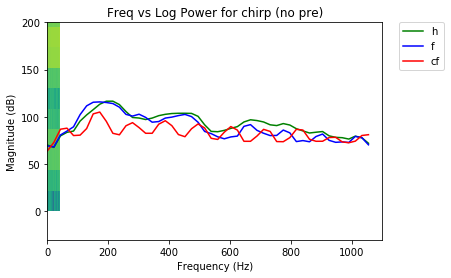

Healthy: 97746.46798902006
Fracture: 94064.91972366987
CF: 87782.67317500841
Suspected transmission rate is: 96.0% compared to the healthy side.


In [14]:


plt.title('Magnitude vs Frequency')
plt.plot(freqs[:50], y_axis[:50], 'g', label="h")
plt.plot(freqs2[:50], y_axis2[:50], 'b', label="f")
#plt.plot(freqs3[:50], y_axis3[:50], 'r', label="cf")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.xlim(0,1100)
    plt.ylim(-30,200)
    plt.show()

area_1 = np.trapz(y_axis[:50], freqs[:50])
area_2 = np.trapz(y_axis2[:50], freqs2[:50])
#area_3 = np.trapz(y_axis3[:50], freqs3[:50])
print("Healthy: " + str(area_1))
print("Fracture: " + str(area_2))
#print("CF: " + str(area_3))

print("Suspected transmission rate is: " + str(np.round(area_2 / area_1, decimals=2) * 100) + "% compared to the healthy side.")

In [27]:
# Begin TensorFlow
# Taken from Neil

sample_rate = 100000
frame_length = 2048
frame_step = 512
fft_length = 4096

audio_file = tf.placeholder(tf.string)

audio_binary = tf.read_file(audio_file)
waveform = tf.contrib.ffmpeg.decode_audio(
    audio_binary,
    file_format="wav",
    samples_per_second=sample_rate,    # Get Info on .wav files (sample rate)
    channel_count=1             # Get Info on .wav files (audio channels)
)

stft = tf.contrib.signal.stft(
    tf.transpose(waveform),
    frame_length,     # frame_lenght, hmmm
    frame_step,     # frame_step, more hmms
    fft_length=fft_length,
    window_fn=functools.partial(tf.contrib.signal.hann_window, periodic=False), # matches audacity
    pad_end=False,
    name="STFT"
)

average_fft = tf.reduce_mean(tf.squeeze(stft), 0)

# https://medium.com/towards-data-science/audio-processing-in-tensorflow-208f1a4103aa
# magnitude spectrum of positive frequencies in dB
abs_fft = tf.abs(average_fft)

def log10(x):
    num = tf.log(x)
    den = tf.log(tf.constant(10, dtype=num.dtype))
    return(tf.div(num, den))

# Add 1 to ensure all powers are greater than 0 (since taking log base 10)
magnitude = 20 * log10(abs_fft + 1)

# Initializing the variables
init = tf.global_variables_initializer()

NameError: name 'tf' is not defined

In [28]:
def get_frequency_spectrum(folder, sensor, fileName):
    with tf.Session() as sess:
        # from tensorflow.python import debug as tf_debug
        # sess = tf_debug.LocalCLIDebugWrapperSession(sess)
        sess.run(init)

        [db_powers] = sess.run([magnitude], feed_dict={
            audio_file: "%s/%s/%s.wav" % (folder, sensor, fileName),
        })

        freq_spectrum = []
        for i in range(db_powers.shape[0]):
            # https://www.quora.com/How-do-I-convert-Complex-number-output-generated-by-FFT-algorithm-into-Frequency-vs-Amplitude
            frequency = i * math.ceil(sample_rate / fft_length)
            freq_spectrum.append([frequency, db_powers[i]])
        return freq_spectrum

fileName = 'brp_f_t06'
freq_spec_arr = get_frequency_spectrum('Round 2', 'brp', fileName)

len_list = len(freq_spec_arr)
freq = np.empty(len_list)
db = np.empty(len_list)
i = 0
for elem in freq_spec_arr:
    freq[i] = elem[0]
    db[i] = elem[1]
    i += 1
plt.plot(freq, db)
plt.xlim(0,1500)
plt.ylabel('Power [dB]')
plt.xlabel('Frequency [Hz]')
plt.title('Frequency Spectrum of ' + fileName)
plt.show()

NameError: name 'tf' is not defined

In [ ]:
folder = 'Round 2/brp'
fileName = 'brp_h_t04'
sampFreq, snd = wav.read(folder + "/" + fileName + '.wav')
sampFreq2, snd2 = wav.read('testing' + "/" + 'chirp_test.wav')

In [ ]:
# ZERO-MEAN 
snd = (snd - snd.mean()) / snd.std()
#snd = snd[50000:1450000] #used for dropouts

# 60 HZ INTERFERENCE NOTCH FILTER
f0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 40.0  # Quality factor
w0 = f0/(sampFreq/2)  # Normalized Frequency
# Design notch filter
b, a = signal.iirnotch(w0, Q)
snd = signal.filtfilt(b, a, snd)




snd2 = (snd2 - snd2.mean()) / snd2.std()

# 60 HZ INTERFERENCE NOTCH FILTER
f0 = 60.0  # Frequency to be removed from signal (Hz)
Q = 40.0  # Quality factor
w0 = f0/(sampFreq/2)  # Normalized Frequency
# Design notch filter
b, a = signal.iirnotch(w0, Q)
snd2 = signal.filtfilt(b, a, snd2)
snd = snd[:1500000]
ps_subtract = snd2-snd

plt.plot(ps_subtract)
plt.show()

In [ ]:
scaled = np.int16(snd/np.max(np.abs(snd)) * 32767)
write(folder + fileName + '_subtracted' + '.wav', 100000, scaled)

## Archived

In [ ]:
sr = 100000
freqs = np.arange(0, (sr/2)-1, 1)
ybegin = snd
fftdata2 = fft(ybegin)
fftdata2 = fftdata2[1:50000]
plt.xlim([0,1000])
plt.plot(freqs, abs(fftdata2))
plt.show()

#REFERENCE: http://digitalsoundandmusic.com/2-3-10-windowing-the-fft/

In [ ]:
#IMPORTANT: ALIGN THE SIGNAL AND MAKE SURE ARRAYS ARE THE SAME SIZE TO RUN THIS.
#TO DO: TRY THE CLAPPING METHOD.
#Refer: https://stackoverflow.com/questions/2445756/how-can-i-calculate-audio-db-level
def mag2db(signal, reference):
    sig = signal.copy()
    ref = reference.copy()
    sig_min = np.amin(sig)
    sig += sig_min #shift up to 0
    sig = sig/65535 #16 bit scaling
    
    ref_min = np.amin(ref)
    ref += ref_min #shift up to 0
    ref= ref/65535 #16 bit scaling between 0 and 1
    
    if len(sig) > len(ref):
        ref = np.pad(reference, (0,len(sig) - len(ref)), 'constant')
        
    elif len(sig) < len(ref):
        sig = np.pad(signal, (0,len(ref) - len(sig)), 'constant')
    
    signal_db = 20*np.log10(np.divide(sig,ref))
    return signal_db


sig_db = mag2db(snd3, snd)

plt.plot(sig_db)
plt.ylabel('dB')
plt.xlabel('sample #')
plt.show()

In [ ]:
#?? i dont know what this is for anymore lol http://samcarcagno.altervista.org/blog/basic-sound-processing-python/?doing_wp_cron=1532489611.3004920482635498046875
n = len(snd) 
p = fft(snd) # take the fourier transform 
nUniquePts = int(np.ceil((n+1)/2.0))
p = p[0:nUniquePts]
p = abs(p)

n2 = len(snd2) #CHANGE HERE AND BELOW
p2 = fft(snd2)
nUniquePts2 = int(np.ceil((n+1)/2.0))
p2 = p2[0:nUniquePts2]
p2 = abs(p2)

In [ ]:
p = p / float(n) # scale by the number of points so that
                 # the magnitude does not depend on the length 
                 # of the signal or on its sampling frequency  
p = p**2  # square it to get the power 

# multiply by two (see technical document for details)
# odd nfft excludes Nyquist point
if n % 2 > 0: # we've got odd number of points fft
    p[1:len(p)] = p[1:len(p)] * 2
else:
    p[1:len(p) -1] = p[1:len(p) - 1] * 2 # we've got even number of points fft
    
p2 = p2 / float(n2) # scale by the number of points so that
                 # the magnitude does not depend on the length 
                 # of the signal or on its sampling frequency  
p2 = p2**2  # square it to get the power 

# multiply by two (see technical document for details)
# odd nfft excludes Nyquist point
if n2 % 2 > 0: # we've got odd number of points fft
    p2[1:len(p2)] = p2[1:len(p2)] * 2
else:
    p2[1:len(p2) -1] = p2[1:len(p2) - 1] * 2 # we've got even number of points fft
    
freqArray = np.arange(0, nUniquePts, 1.0) * (sampFreq / n);
fig = plt.figure()
plt.plot(freqArray/1000, 10*np.log10(p2/p), color='k')
plt.title('dB of ' + fileName + ' compared to ' + fileName2) #CHANGE HERE
plt.xlabel('Frequency (kHz)')
plt.ylabel('Power (dB)')
plt.xlim([0,0.5])
plt.show()

In [ ]:
rms_val = np.sqrt(np.mean(snd**2))
print(rms_val)
print(np.sqrt(np.sum(p)))

rms_val2 = np.sqrt(np.mean(snd2**2))
print(rms_val2)
print(np.sqrt(np.sum(p2)))